# Anchor A — Ingest & First Charts (WDI)
Loads World Bank WDI bundles for:
- **SN.ITK.DEFC.ZS** — Prevalence of undernourishment (% of population)
- **FP.CPI.TOTL** — Consumer price index (2010=100)

Filters to TZA, KEN, UGA, RWA; saves small cleaned samples and two figures.


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

# Project paths (works whether you run from notebooks/ or project root)
root = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
data_ext = root / "data" / "external"
data_sam = root / "data" / "sample"
figs = root / "assets"

# Ensure output folders exist
data_sam.mkdir(parents=True, exist_ok=True)
figs.mkdir(parents=True, exist_ok=True)

print("Project root:", root)
print("External data:", data_ext)
print("Sample data:", data_sam)
print("Figures:", figs)


Matplotlib is building the font cache; this may take a moment.


Project root: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio
External data: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\data\external
Sample data: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\data\sample
Figures: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\assets


In [2]:
def read_wdi_main_csv(path: Path) -> pd.DataFrame:
    """
    Read the MAIN World Bank WDI CSV from an API bundle.
    These usually have 4 header rows before the real header.
    Falls back gracefully if the file has a different layout.
    """
    # Try the common 'skiprows=4' pattern first
    try:
        df = pd.read_csv(path, skiprows=4)
    except Exception:
        df = pd.read_csv(path)

    # Drop fully empty columns (often trailing)
    df = df.dropna(axis=1, how='all')

    # Keep standard ID columns + year columns (numeric-like)
    year_cols = [c for c in df.columns if str(c).isdigit()]
    keep = ["Country Name", "Country Code", "Indicator Name", "Indicator Code"] + year_cols
    # Some bundles may have slightly different capitalization—intersect defensively
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    return df

def tidy_wdi(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform WDI wide-year format into long format with columns:
    Country Name | Country Code | Indicator Name | Indicator Code | Year | Value
    """
    year_cols = [c for c in df.columns if str(c).isdigit()]
    long = df.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        value_vars=year_cols, var_name="Year", value_name="Value"
    )
    long["Year"] = pd.to_numeric(long["Year"], errors="coerce")
    long["Value"] = pd.to_numeric(long["Value"], errors="coerce")
    long = long.dropna(subset=["Year", "Value"]).sort_values(["Country Name", "Year"])
    return long

def latest_api_file(pattern: str) -> Path:
    """
    Return the latest-matching API CSV in data/external (sorted lexicographically).
    Example pattern: 'API_SN.ITK.DEFC.ZS_DS2_en_csv_v2_*.csv'
    """
    matches = sorted(data_ext.glob(pattern))
    if not matches:
        raise FileNotFoundError(f"No files matched pattern: {pattern}\n"
                                f"Looked in: {data_ext}\n"
                                f"Tip: Put your WDI 'API_*.csv' main files in data/external/")
    return matches[-1]

def year_span_str(df: pd.DataFrame, year_col="Year") -> str:
    """Return a label like '2000_2024' based on min/max year in a tidy frame."""
    years = pd.to_numeric(df[year_col], errors="coerce").dropna()
    return f"{int(years.min())}_{int(years.max())}" if not years.empty else "na_na"

def plot_lines_long(df: pd.DataFrame, title: str, ylab: str, outfile: Path):
    """Simple multi-country line plot from tidy WDI long format."""
    plt.figure()
    for name, sub in df.groupby("Country Name"):
        sub = sub.sort_values("Year")
        plt.plot(sub["Year"], sub["Value"], label=name)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylab)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.show()
    print("Saved figure:", outfile)


In [6]:
# Find the latest bundles you downloaded from WDI (the "API_*.csv" MAIN files)
pou_main = latest_api_file("API_SN.ITK.DEFC.ZS_DS2_en_csv_v2_*.csv")   # Prevalence of undernourishment
cpi_main = latest_api_file("API_FP.CPI.TOTL_DS2_en_csv_v2_*.csv")      # CPI (2010=100)

print("POU main CSV:", pou_main.name)
print("CPI main CSV:", cpi_main.name)

# Read & tidy
pou_raw = read_wdi_main_csv(pou_main)
cpi_raw = read_wdi_main_csv(cpi_main)

pou_long = tidy_wdi(pou_raw)
cpi_long = tidy_wdi(cpi_raw)

# Filter to your countries (Tanzania, Kenya, Uganda, Rwanda)
CODES = ["TZA", "KEN", "UGA", "RWA"]
pou = pou_long[pou_long["Country Code"].isin(CODES)].copy()
cpi = cpi_long[cpi_long["Country Code"].isin(CODES)].copy()

print("POU rows (filtered):", len(pou))
print("CPI rows (filtered):", len(cpi))
pou.head()


POU main CSV: API_SN.ITK.DEFC.ZS_DS2_en_csv_v2_752632.csv
CPI main CSV: API_FP.CPI.TOTL_DS2_en_csv_v2_752562.csv
POU rows (filtered): 88
CPI rows (filtered): 215


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
121,Kenya,KEN,Prevalence of undernourishment (% of population),SN.ITK.DEFC.ZS,2001,31.9
387,Kenya,KEN,Prevalence of undernourishment (% of population),SN.ITK.DEFC.ZS,2002,33.4
653,Kenya,KEN,Prevalence of undernourishment (% of population),SN.ITK.DEFC.ZS,2003,34.7
919,Kenya,KEN,Prevalence of undernourishment (% of population),SN.ITK.DEFC.ZS,2004,31.8
1185,Kenya,KEN,Prevalence of undernourishment (% of population),SN.ITK.DEFC.ZS,2005,28.2


In [7]:
# Keep recent years if you like (e.g., from 2000 onward). Adjust as needed.
pou_recent = pou.query("Year >= 2000").copy()
cpi_recent = cpi.query("Year >= 2000").copy()

span_pou = year_span_str(pou_recent)
span_cpi = year_span_str(cpi_recent)

# Alphabetical ISO3 for geo label
geo_label = "-".join(sorted(CODES, key=str.lower)).lower()  # 'ken-rwa-tza-uga'
today = date.today().strftime("%Y%m%d")

pou_out = data_sam / f"wdi_sn.itk.defc.zs_{geo_label}_{span_pou}.csv"
cpi_out = data_sam / f"wdi_fp.cpi.totl_{geo_label}_{span_cpi}.csv"

pou_recent.to_csv(pou_out, index=False)
cpi_recent.to_csv(cpi_out, index=False)

print("Saved sample CSVs:")
print("  ", pou_out)
print("  ", cpi_out)


Saved sample CSVs:
   c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\data\sample\wdi_sn.itk.defc.zs_ken-rwa-tza-uga_2001_2022.csv
   c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\data\sample\wdi_fp.cpi.totl_ken-rwa-tza-uga_2000_2024.csv


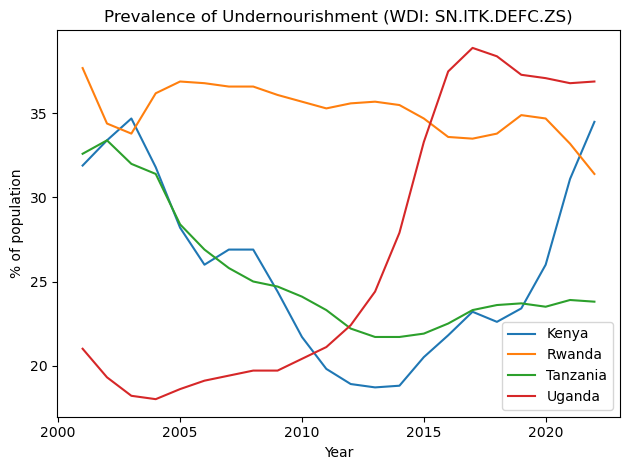

Saved figure: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\assets\anchor_a_pou_ken-rwa-tza-uga.png


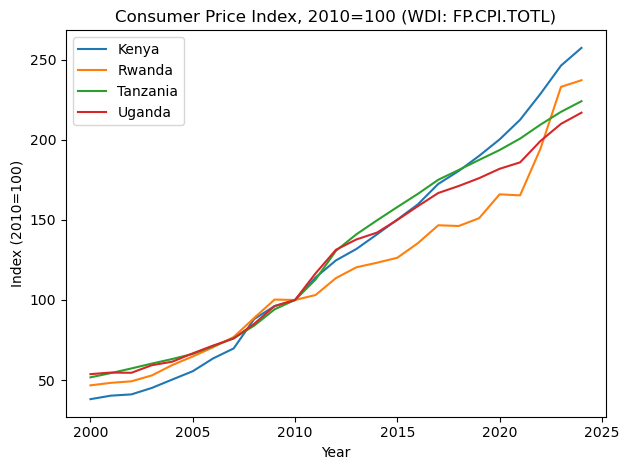

Saved figure: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\assets\anchor_a_cpi_ken-rwa-tza-uga.png


In [8]:
fig_pou = figs / f"anchor_a_pou_{geo_label}.png"
fig_cpi = figs / f"anchor_a_cpi_{geo_label}.png"

plot_lines_long(
    pou_recent, 
    title="Prevalence of Undernourishment (WDI: SN.ITK.DEFC.ZS)",
    ylab="% of population",
    outfile=fig_pou
)

plot_lines_long(
    cpi_recent, 
    title="Consumer Price Index, 2010=100 (WDI: FP.CPI.TOTL)",
    ylab="Index (2010=100)",
    outfile=fig_cpi
)


In [9]:
def latest_by_country(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each country, grab the most recent Year with a non-null Value and report Value.
    """
    latest_rows = []
    for (cc, cn), sub in df.dropna(subset=["Value"]).groupby(["Country Code", "Country Name"]):
        sub = sub.sort_values("Year")
        last = sub.iloc[-1]
        latest_rows.append({
            "Country Code": cc,
            "Country Name": cn,
            "Latest Year": int(last["Year"]),
            "Latest Value": float(last["Value"])
        })
    return pd.DataFrame(latest_rows).sort_values(["Country Name"])

summary_pou = latest_by_country(pou_recent)
summary_cpi = latest_by_country(cpi_recent)

print("Latest POU values (most recent year per country):")
display(summary_pou)

print("Latest CPI values (most recent year per country):")
display(summary_cpi)


Latest POU values (most recent year per country):


,Country Code,Country Name,Latest Year,Latest Value
0,KEN,Kenya,2022,34.5
1,RWA,Rwanda,2022,31.4
2,TZA,Tanzania,2022,23.8
3,UGA,Uganda,2022,36.9


Latest CPI values (most recent year per country):


,Country Code,Country Name,Latest Year,Latest Value
0,KEN,Kenya,2024,257.353393
1,RWA,Rwanda,2024,237.161344
2,TZA,Tanzania,2024,224.080828
3,UGA,Uganda,2024,216.908166


## Next Steps
- Write 2–3 sentences for **Findings** in `reports/anchor_a_brief.md`, referencing these charts.
- Consider adding one more affordability/availability proxy (e.g., food share of consumption, if available).
- Start **Anchor B** (QGIS): compile OSM markets/roads and build a simple travel-time map.
